In [62]:
import json
import pandas as pd
import sys

sys.path.append("../")

from config import DATA_DIR
from graph_types.graph import Graph

graph_name = "prime"

In [63]:
logs_dir = DATA_DIR / f"experiments/{graph_name}/subgraph_explorer"
json_files = sorted([f for f in logs_dir.glob("*.json")], key=lambda x: x.stat().st_ctime)

data = []

for json_file in json_files:
    with open(json_file, "r") as f:
        log_data = json.load(f)

    # Extract key information from each log entry
    record = {
        "file_id": int(json_file.stem),
        "question": log_data.get("question", ""),
        "all_nodes": log_data.get("all_nodes", []),
        "message_histories": log_data.get("message_histories", ""),
        "starting_nodes_indices": log_data.get("starting_nodes_indices", []),
        "agent_answer_indices": log_data.get("agent_answer_indices", []),
        "answer_indices": log_data.get("answer_indices", []),
    }

    data.append(record)

df = pd.DataFrame(data).reset_index(drop=True)# .sort_values(by="file_id").reset_index(drop=True)

df["recall@all"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"])))
    / len(set(row["answer_indices"])),
    axis=1,
)
df["hit@1"] = df.apply(
    lambda row: (
        row["agent_answer_indices"][0] in row["answer_indices"]
        if row["agent_answer_indices"]
        else False
    ),
    axis=1,
)
df["hit@5"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"][:5])))
    > 0,
    axis=1,
)
df["hit@10"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"][:10])))
    > 0,
    axis=1,
)
df["recall@10"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"][:10])))
    / len(set(row["answer_indices"])),
    axis=1,
)
df["recall@20"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"][:20])))
    / len(set(row["answer_indices"])),
    axis=1,
)

[
    ("n", len(df)),
    ("Hit@1", float(round(df["hit@1"].mean(), 3))),
    ("Hit@5", float(round(df["hit@5"].mean(), 3))),
    ("Recall@10", float(round(df["recall@10"].mean(), 3))),
    ("Recall@20", float(round(df["recall@20"].mean(), 3))),
    ("Recall@all", float(round(df["recall@all"].mean(), 3))),
]

[('n', 43),
 ('Hit@1', 0.326),
 ('Hit@5', 0.605),
 ('Recall@10', 0.581),
 ('Recall@20', 0.589),
 ('Recall@all', 0.6)]

### What's the difference between the good and the bad conversations?

In [64]:
df['recall@20'].value_counts()

recall@20
1.000000    23
0.000000    16
0.500000     2
0.777778     1
0.538462     1
Name: count, dtype: int64

In [65]:
df_recall_1 = df[df['recall@20'] == 1]
df_recall_0 = df[df['recall@20'] == 0]

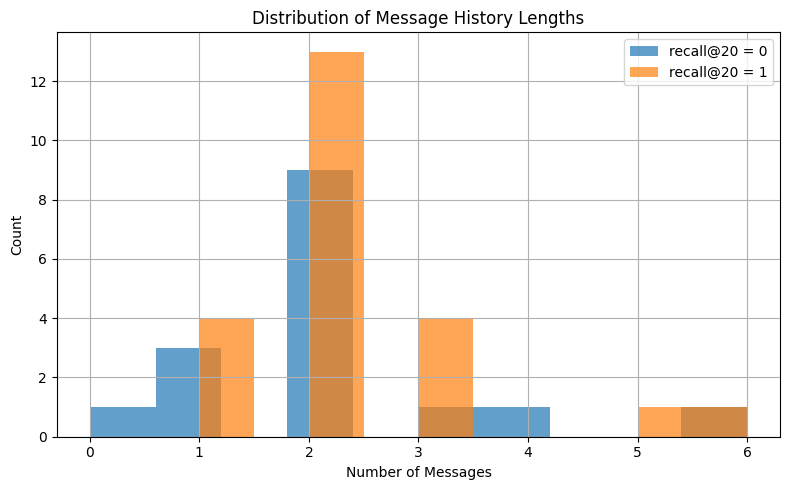

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
df_recall_0["message_histories"].apply(len).hist(alpha=0.7, label="recall@20 = 0")
df_recall_1["message_histories"].apply(len).hist(alpha=0.7, label="recall@20 = 1")
plt.xlabel("Number of Messages")
plt.ylabel("Count")
plt.title("Distribution of Message History Lengths")
plt.legend()
plt.tight_layout()
plt.show()

In [67]:
conversations_w_recall_1 = []
for set_of_conversations_w_recall_1 in df_recall_1["message_histories"].tolist():
    for conversation in set_of_conversations_w_recall_1:
        conversations_w_recall_1.append(conversation)

conversations_w_recall_0 = []
for set_of_conversations_w_recall_0 in df_recall_0["message_histories"].tolist():
    for conversation in set_of_conversations_w_recall_0:
        conversations_w_recall_0.append(conversation)

In [68]:
import json

def parse_conversation(conversation):
    """Parse conversation data and return readable formatted string"""
    if isinstance(conversation, str):
        try:
            conversation = eval(conversation)
        except:
            return "Error: Could not parse conversation data"
    
    output = []
    output.append("=" * 60)
    output.append("CONVERSATION ANALYSIS")
    output.append("=" * 60)
    
    # Summary
    total = len(conversation)
    user_count = sum(1 for msg in conversation if msg['role'] == 'user')
    assistant_count = sum(1 for msg in conversation if msg['role'] == 'assistant')
    tool_count = sum(1 for msg in conversation if msg['role'] == 'tool')
    
    output.append(f"Total Messages: {total}")
    output.append(f"User: {user_count}, Assistant: {assistant_count}, Tool: {tool_count}")
    output.append("")
    
    # Messages
    for i, message in enumerate(conversation):
        output.append(f"[{i + 1}] {message['role'].upper()}")
        output.append("-" * 30)
        
        if message.get('content'):
            output.append(f"Content: {message['content']}")
        
        if 'tool_calls' in message:
            output.append("Tool Calls:")
            for tool_call in message['tool_calls']:
                output.append(f"  • Function: {tool_call['function']['name']}")
                output.append(f"    ID: {tool_call['id']}")
                if tool_call['function']['arguments']:
                    args = json.loads(tool_call['function']['arguments'])
                    output.append(f"    Args: {args}")
        
        if 'tool_call_id' in message:
            output.append(f"Response to: {message['tool_call_id']}")
        
        output.append("")
    
    return "\n".join(output)

In [69]:
parsed_conversations_w_recall_0 = [
    parse_conversation(conversation) for conversation in conversations_w_recall_0
]
parsed_conversations_w_recall_1 = [
    parse_conversation(conversation) for conversation in conversations_w_recall_1
]

In [74]:
prompt = "Please analyze the following conversation data and provide insights."
prompt += '\n'
prompt += "Set 0 of conversations"
prompt += '\n'
prompt += "\n".join(parsed_conversations_w_recall_0[10:40])
prompt += '\n\n'
prompt += "Set 1 of conversations"
prompt += '\n'
prompt += "\n".join(parsed_conversations_w_recall_1[10:40])
prompt += '\n\n'
prompt += "Can you explain if you find any differences between how the two sets?"

In [75]:
print(prompt)

Please analyze the following conversation data and provide insights.
Set 0 of conversations
CONVERSATION ANALYSIS
Total Messages: 22
User: 1, Assistant: 10, Tool: 11

[1] USER
------------------------------
Content: Question: Which gene or protein interacts with both PRKCB and glycogen synthase kinase-3 beta, exhibiting a shared effect or phenotype as documented in prior research?

You are starting your exploration at node: **PRKCB**

## Your Mission
Find all nodes in this knowledge graph that answer the given question. You have been placed at this starting node because it's strategically relevant to the question.

## Recommended First Steps
1. **Understand your starting point**: Use `search_in_surroundings(k=1, query="")` to see what's immediately connected to your current node
2. **Identify the answer type**: Based on the question, determine what type of nodes you're looking for (papers, genes, products, etc.)
3. **Begin systematic exploration**: Use the available tools to explore th